In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from py_utils.utils import state_cols
from py_utils.result_plot import plot_track, plot_trajectories

In [2]:
data_path = os.path.join('..', '..', '..', '..', '..', '..', '..', 'data',
                                             'ferrari', 'driver', 'datasets', 'same_setup', 'csv')
track_file_name = 'ds_with_last_budapest_10'
rt_file_name = 'no_proc_rt_same_setup_budapest'

simulation = pd.read_csv(os.path.join(data_path, track_file_name + '.csv'))
ref_tr = pd.read_csv(os.path.join(data_path, rt_file_name + '.csv'))

In [3]:
track_in_file_name = 'budapest_InnerTrackEdge.csv'
track_out_file_name = 'budapest_OuterTrackEdge.csv'
track_in = pd.read_csv(os.path.join(data_path, track_in_file_name))
track_out = pd.read_csv(os.path.join(data_path, track_out_file_name))

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


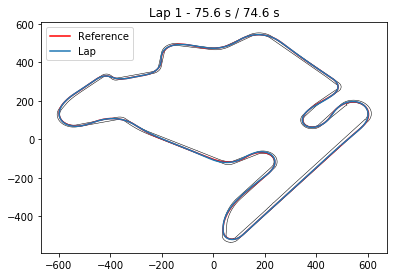

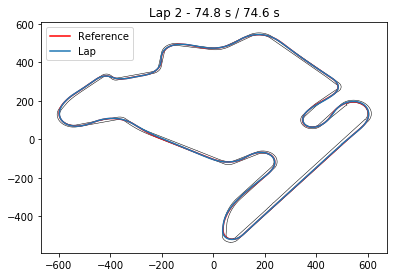

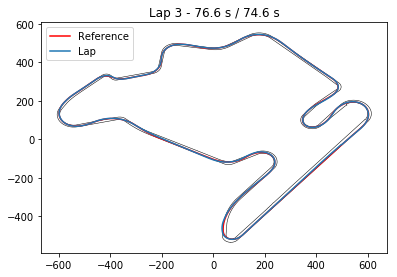

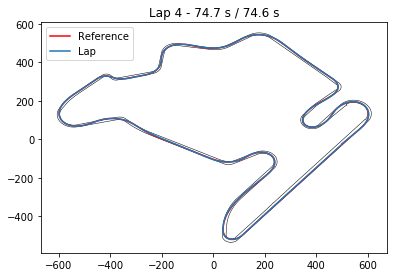

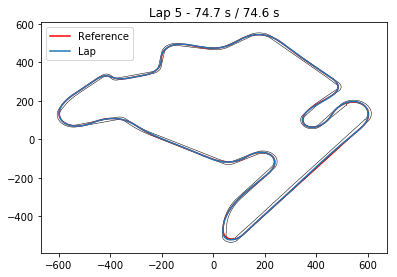

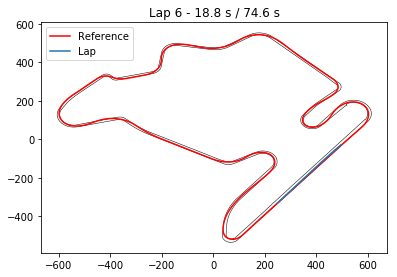

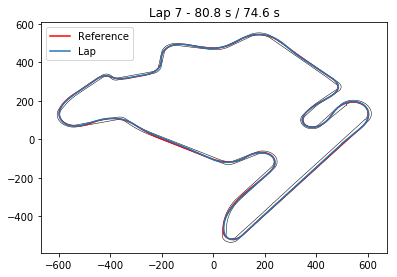

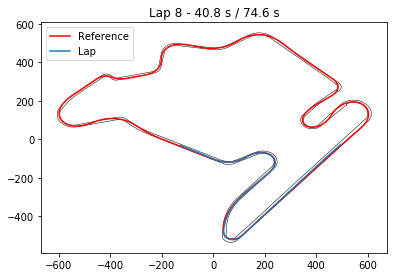

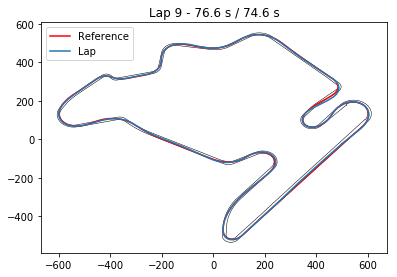

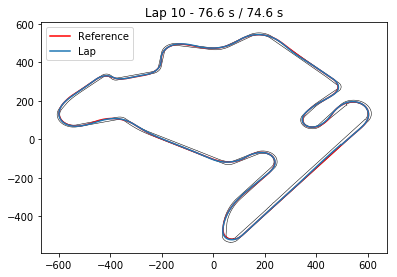

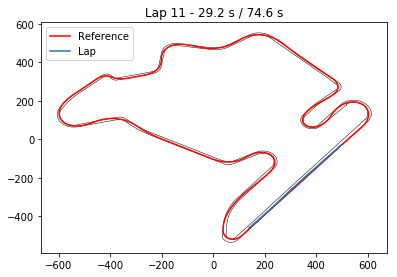

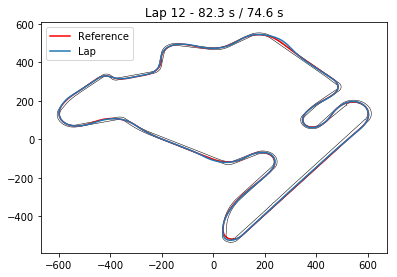

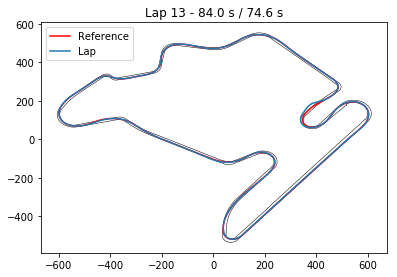

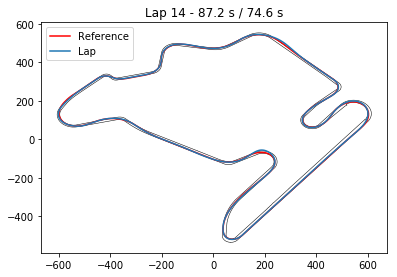

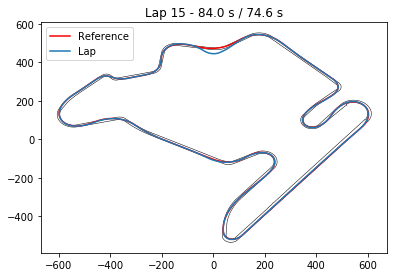

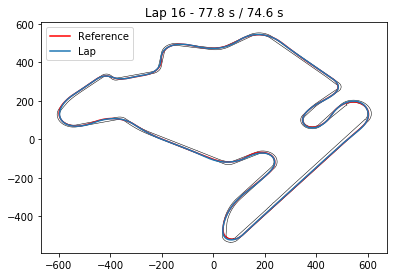

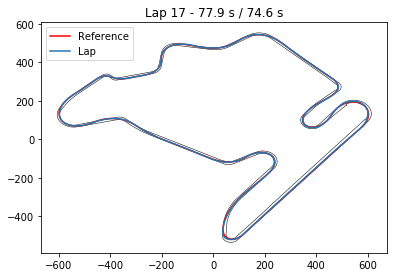

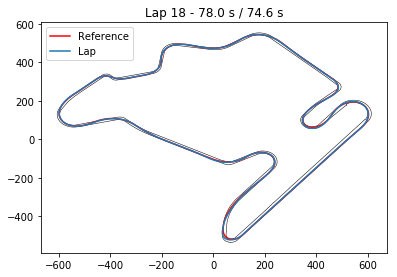

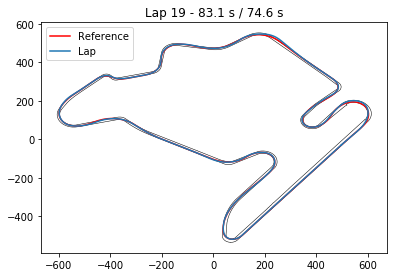

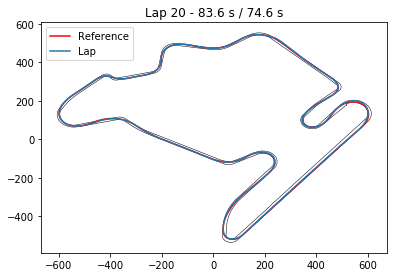

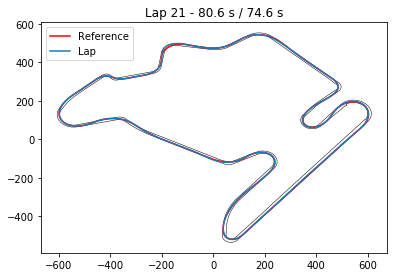

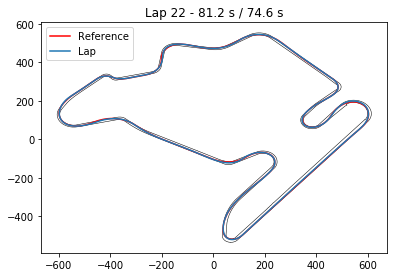

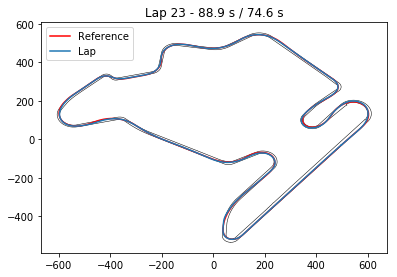

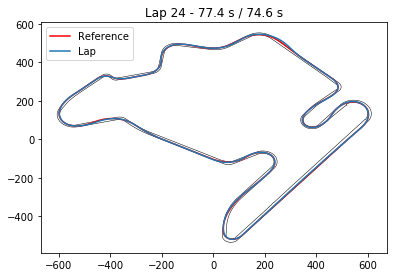

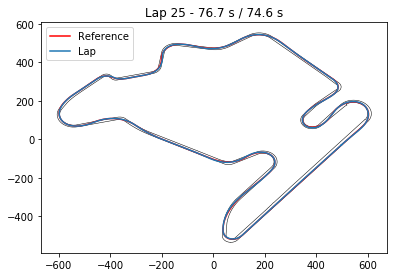

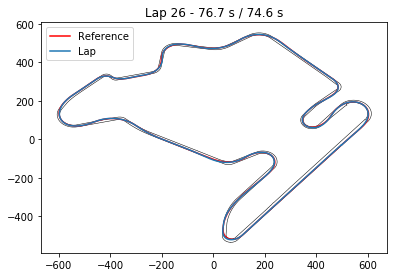

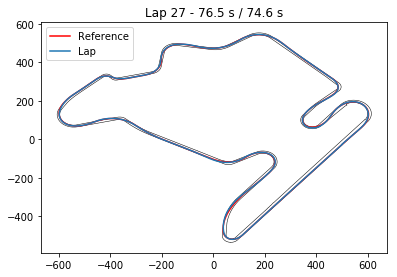

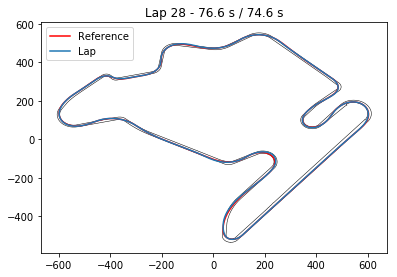

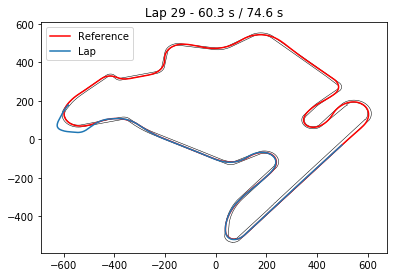

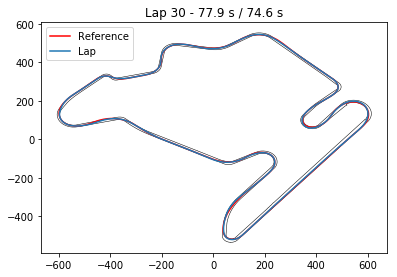

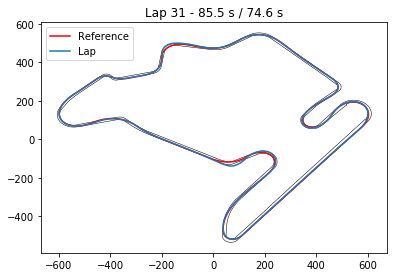

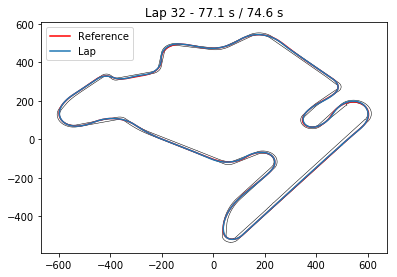

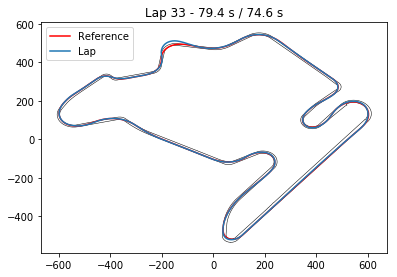

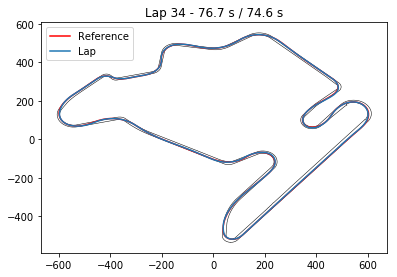

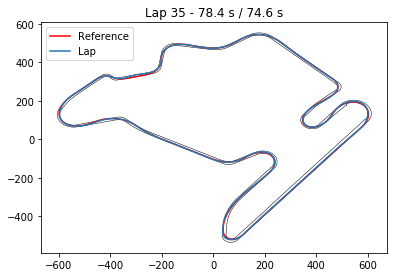

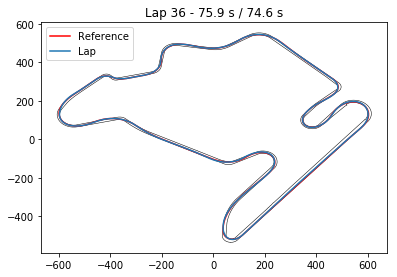

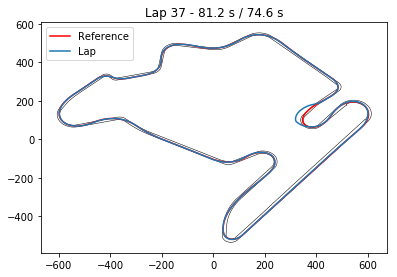

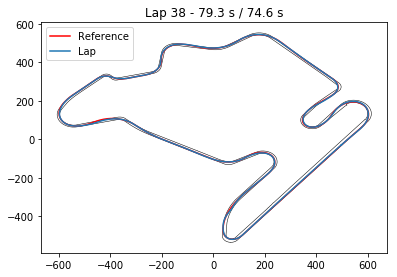

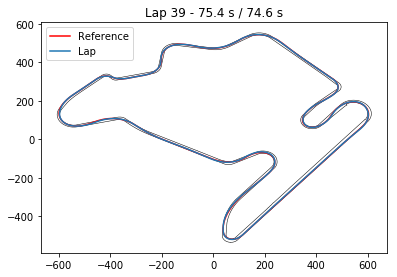

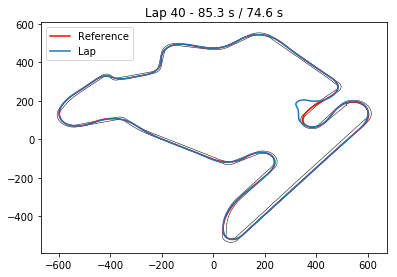

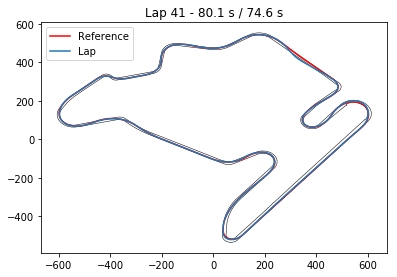

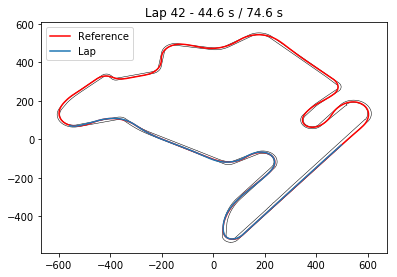

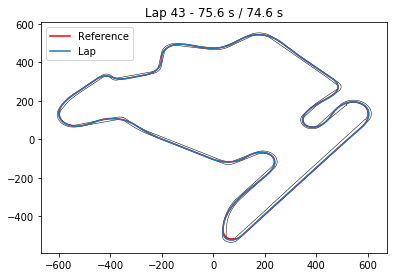

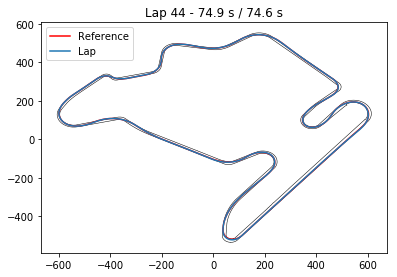

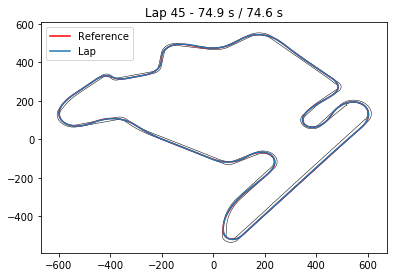

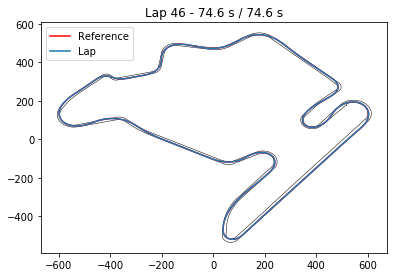

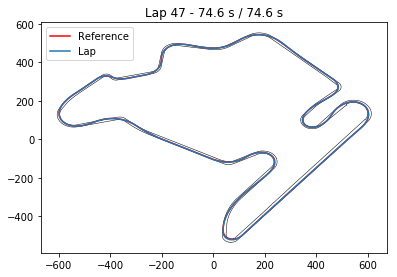

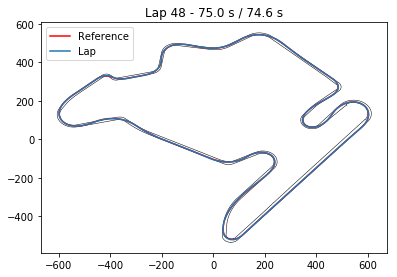

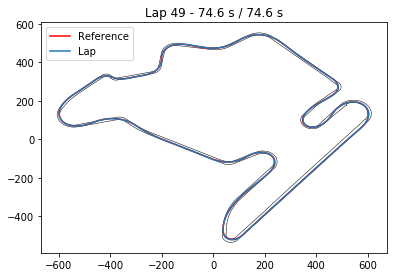

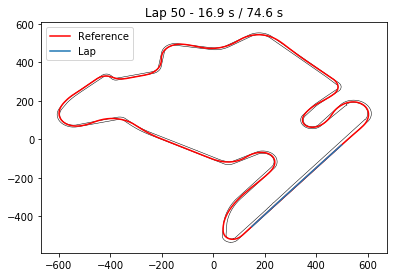

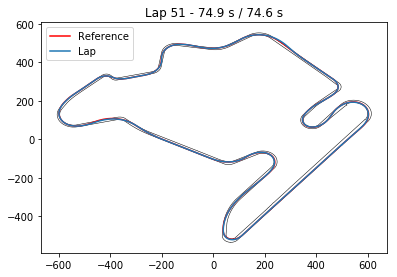

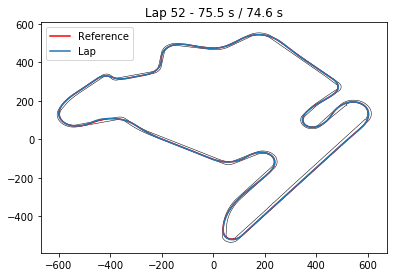

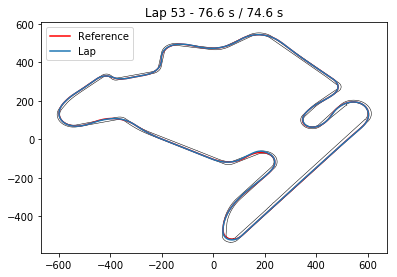

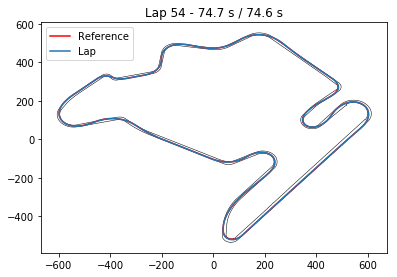

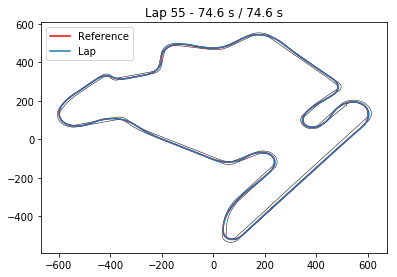

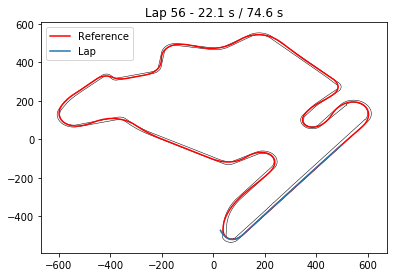

In [4]:
for lap in set(simulation.NLap):
    f, ax = plot_track(track_in, track_out)
    plot_trajectories(simulation, lap, f, ax, simulation[simulation.NLap == 46])

# Train and test split

In [4]:
all_laps = np.unique(simulation.NLap)
lap_times = map(lambda lap: simulation[simulation.NLap == lap]['time'].values[-1], all_laps)
ref_time = ref_tr['time'].values[-1]
perc_deltas = list(map(lambda t: (abs(t - ref_time) / ref_time * 100) <= 1.5, lap_times))
right_laps = all_laps[perc_deltas]

In [5]:
right_laps

array([ 1,  2,  4,  5, 39, 43, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55])

In [6]:
for lap in right_laps:
    lap_df = simulation[simulation.NLap == lap]
    time = lap_df['time'].values[-1]
    print('Lap {}: {} s'.format(lap, time))

wrong_laps = [6, 7, 29, 31, 33, 37, 40]

train_laps = right_laps[:-1]
test_laps = wrong_laps + [right_laps[-1]]

Lap 1: 75.6 s
Lap 2: 74.8 s
Lap 4: 74.7 s
Lap 5: 74.7 s
Lap 39: 75.4 s
Lap 43: 75.6 s
Lap 44: 74.9 s
Lap 45: 74.9 s
Lap 46: 74.6 s
Lap 47: 74.6 s
Lap 48: 75.0 s
Lap 49: 74.6 s
Lap 51: 74.9 s
Lap 52: 75.5 s
Lap 54: 74.7 s
Lap 55: 74.6 s


# Kernel Density estimation X,Y coordinates

As initial estimation we consider only the x,y coordinates of the car. This allows us to visualize the data and the estimations. Among all the laps we choose the right ones i.e., laps in which the car is inside the track and the other state variables are correct. Thus, we remove partial laps, out-track laps and laps where the pilot went low or braked in wrong situations.
Unfortunately this requires manual inspection of the laps to choose the right ones.
To have a first selection we take the laps with lap time delta wrt the reference trajectory at most 1.5%.

In [8]:
xy = simulation[simulation.NLap.isin(train_laps)][['xCarWorld', 'yCarWorld']].values
print('Train shape: {}'.format(xy.shape))

Train shape: (11259, 2)


## KDE Fit

In [9]:
params = {'bandwidth': np.logspace(-1, 1, 20)}
np.random.seed(1)
ids = np.arange(xy.shape[0])
np.random.shuffle(ids)
xy_shfl = xy[ids, :]

search = GridSearchCV(KernelDensity(kernel='gaussian'), param_grid=params, cv=10, n_jobs=10)
search.fit(xy_shfl)

GridSearchCV(cv=10, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'bandwidth': array([ 0.1    ,  0.12743,  0.16238,  0.20691,  0.26367,  0.33598,
        0.42813,  0.54556,  0.69519,  0.88587,  1.12884,  1.43845,
        1.83298,  2.33572,  2.97635,  3.79269,  4.83293,  6.15848,
        7.8476 , 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
search.best_params_

{'bandwidth': 0.6951927961775606}

In [12]:
kde = KernelDensity(kernel='gaussian', bandwidth=search.best_params_['bandwidth']).fit(xy)

## Train Lap Estimate

In [36]:
def plot_proba(X_plot, Y_plot, X_test, log=False, _3d=True):

    log_dens = kde.score_samples(X_test)
    if log:
        dens_to_plot = log_dens
    else:
        dens_to_plot = np.exp(log_dens)
    
    if _3d:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        ax.set_ylabel('y')
        ax.set_xlabel('x')
        ax.set_zlabel('z')
        ax.plot(X_plot, Y_plot, '.', markersize=1)
        ax.plot(track_in.x, track_in.y, 'k', linewidth=0.5)
        ax.plot(track_out.x, track_out.y, 'k', linewidth=0.5)
        
        lw = 2

        ax.plot(X_plot, Y_plot, dens_to_plot, color='darkorange', lw=lw,
                linestyle='-', label="kernel = 'gaussian'")

    fig2,ax2 = plot_track(track_in, track_out)
    s = ax2.scatter(X_plot, Y_plot, c=dens_to_plot.reshape(-1, 1), s=2)
    cbar = fig2.colorbar(s, ax=ax2)
    ax2.set_title('Density estimation Gaussian kernel');
    cbar.ax.set_ylabel('LogP' if log else 'P', rotation=-90, va="bottom")
    
    
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.plot(dens_to_plot)

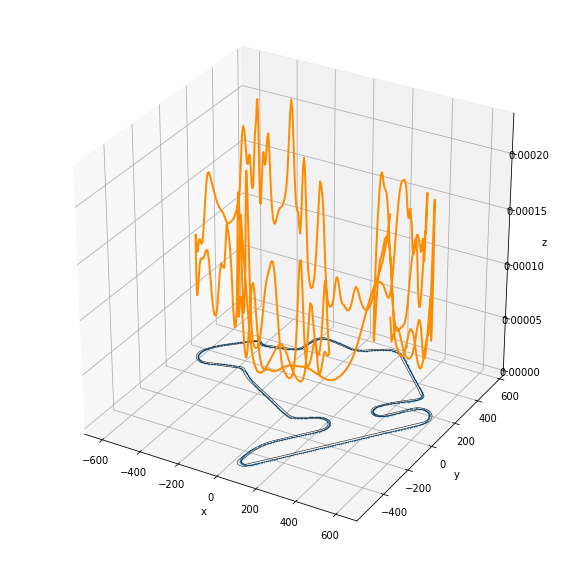

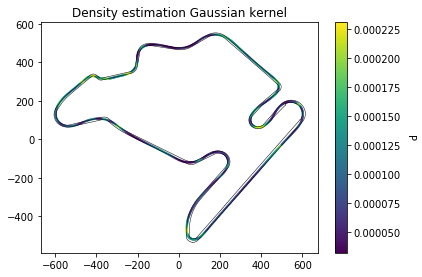

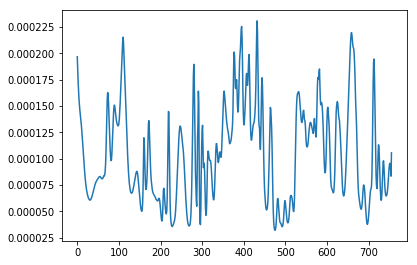

In [14]:
plot_proba(simulation[simulation.NLap.isin([train_laps[0]])][['xCarWorld']].values,
           simulation[simulation.NLap.isin([train_laps[0]])][['yCarWorld']].values,
           simulation[simulation.NLap.isin([train_laps[0]])][['xCarWorld', 'yCarWorld']],
           log=False, _3d=True)

## Test estimates

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


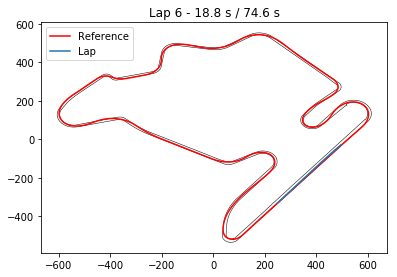

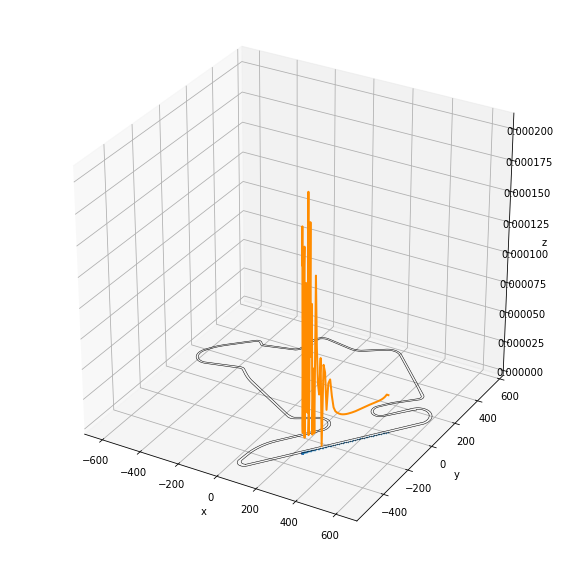

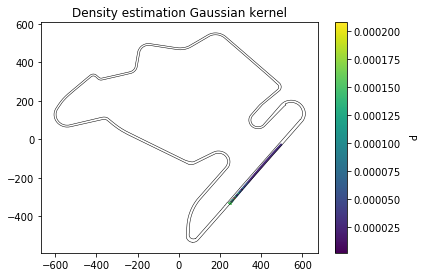

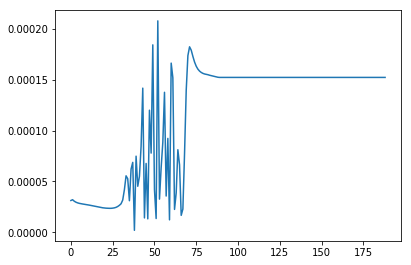

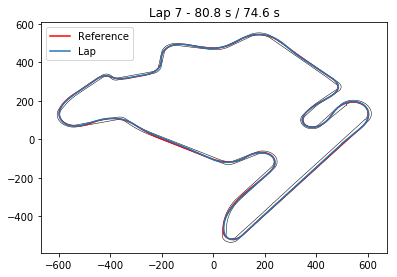

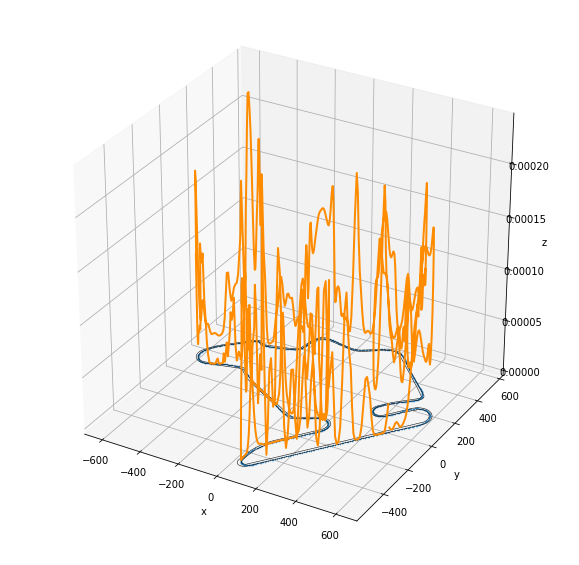

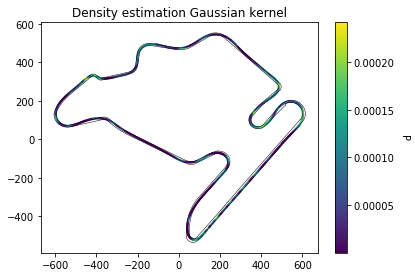

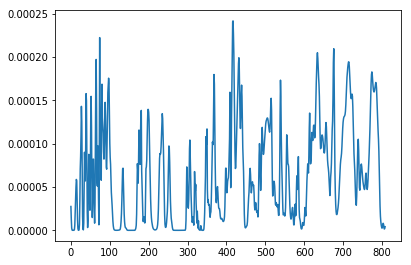

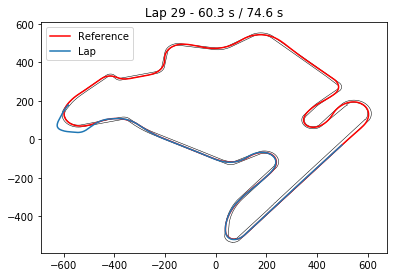

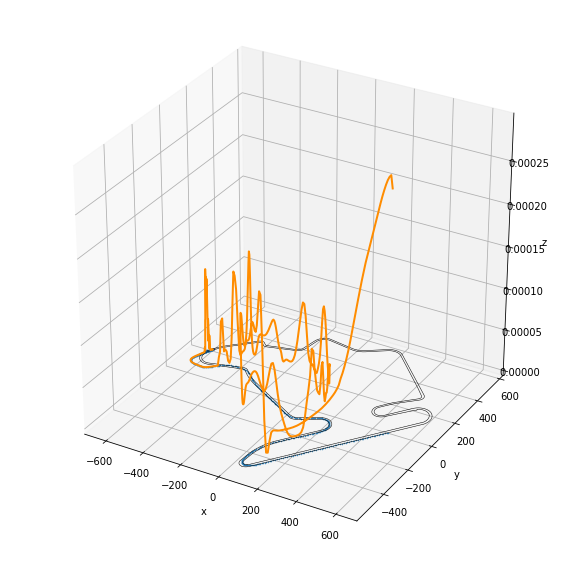

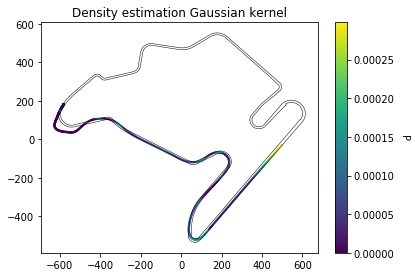

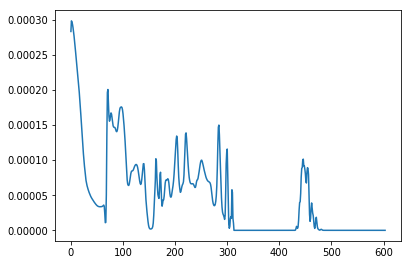

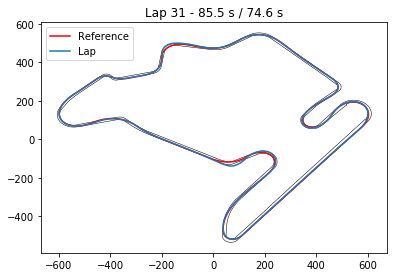

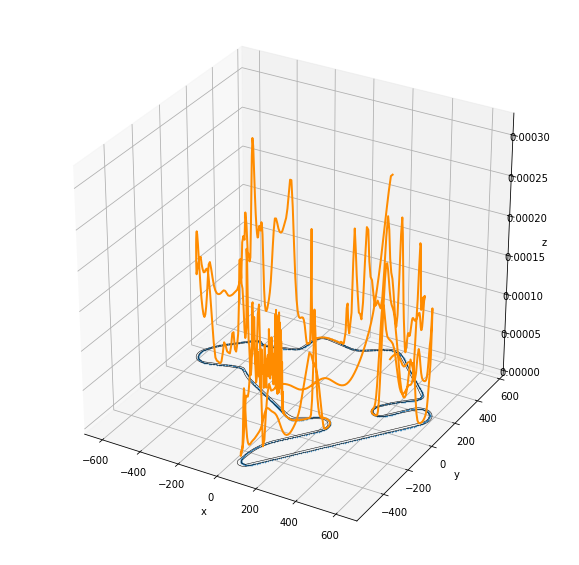

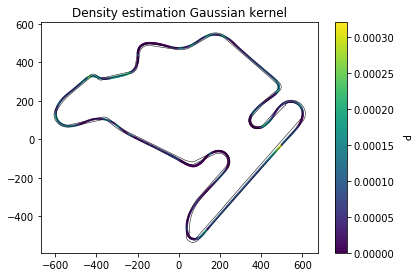

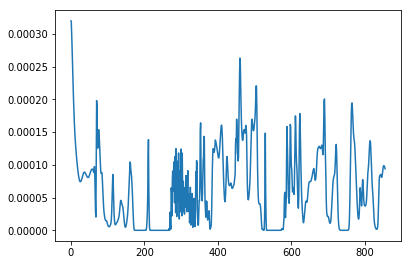

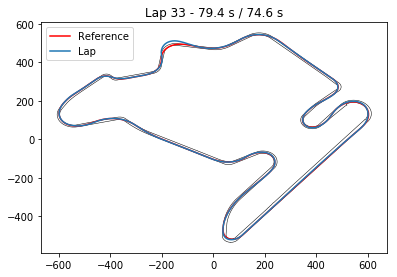

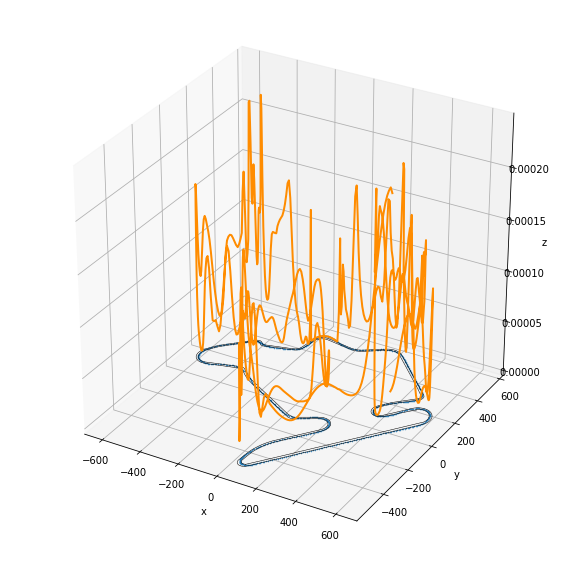

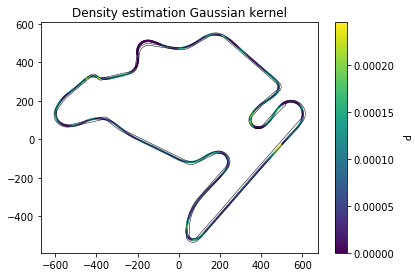

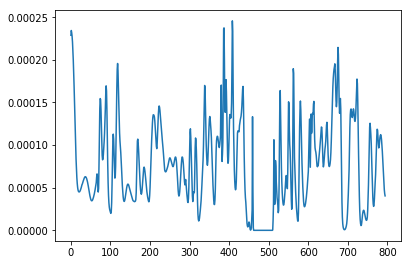

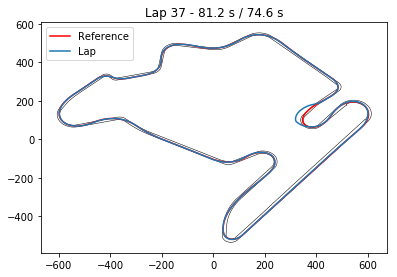

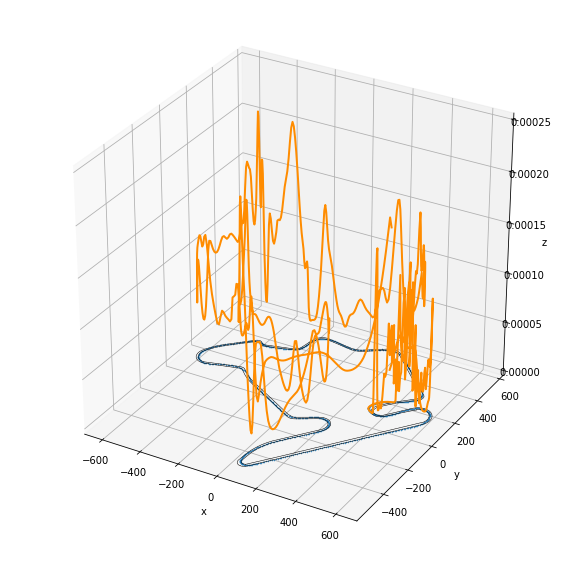

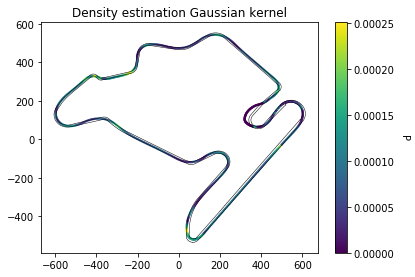

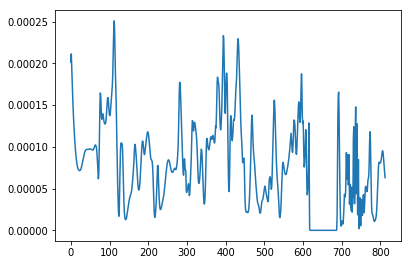

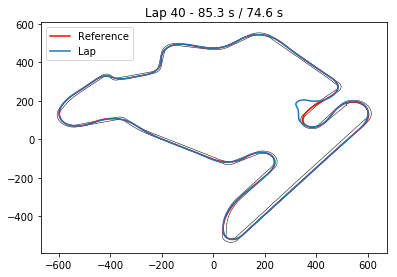

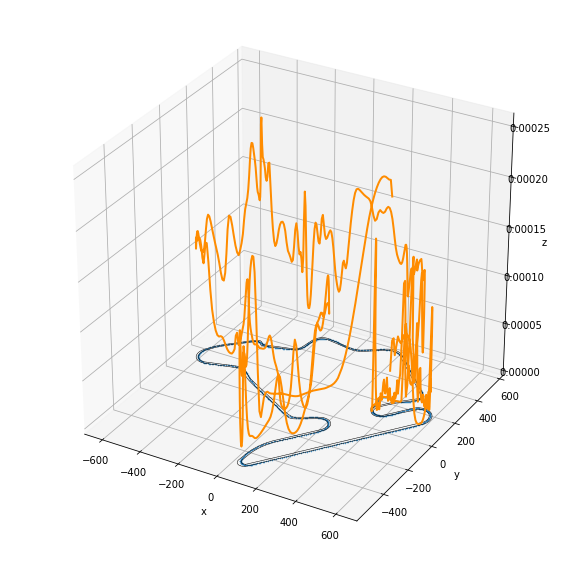

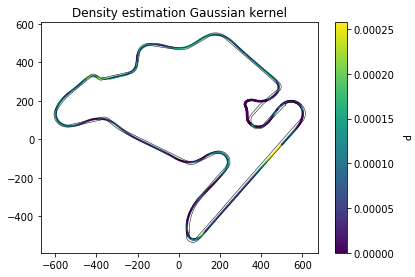

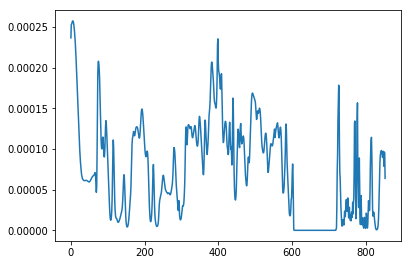

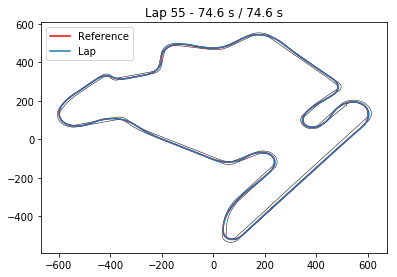

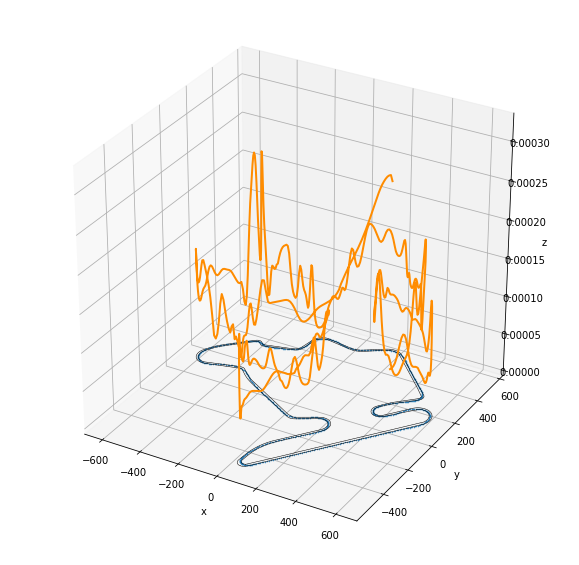

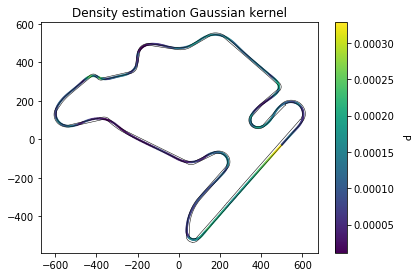

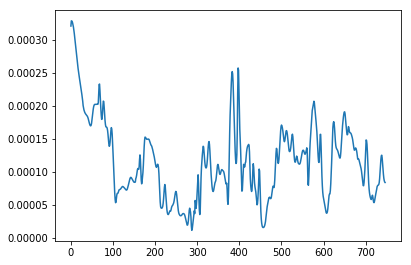

In [15]:
for lap in test_laps:
    f, ax = plot_track(track_in, track_out)
    plot_trajectories(simulation, lap, f, ax, simulation[simulation.NLap == 46])
    
    plot_proba(simulation[simulation.NLap == lap][['xCarWorld']].values,
               simulation[simulation.NLap == lap][['yCarWorld']].values,
               simulation[simulation.NLap == lap][['xCarWorld', 'yCarWorld']].values,
               log=False, _3d=True)

# Kernel Density estimation full state

Now we use the full state vector, this allow us to detect the states that are in the right position of the track but that have strange features, for instance, low speed during straight.

In [29]:
X = simulation[simulation.NLap.isin(train_laps)][state_cols].values
print('Train shape: {}'.format(X.shape))

Train shape: (11259, 18)


## KDE Fit

In [32]:
%%time
params = {'bandwidth': np.logspace(-1, 1, 20), 'kernel':['gaussian', 'epanechnikov', 'exponential']}
np.random.seed(1)
ids = np.arange(X.shape[0])
np.random.shuffle(ids)
X_shfl = X[ids, :]

search = GridSearchCV(KernelDensity(kernel='gaussian'), param_grid=params, cv=10, n_jobs=10)
_= search.fit(X_shfl)

CPU times: user 3.85 s, sys: 320 ms, total: 4.17 s
Wall time: 7min 23s


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


In [33]:
search.best_params_

{'bandwidth': 0.8858667904100825, 'kernel': 'exponential'}

In [34]:
kde = KernelDensity(**search.best_params_).fit(X)

## Train estimation

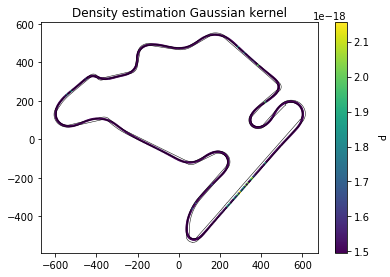

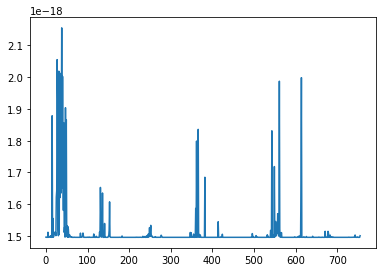

In [37]:
lap = train_laps[0]

plot_proba(simulation[simulation.NLap == lap][['xCarWorld']].values,
           simulation[simulation.NLap == lap][['yCarWorld']].values,
           simulation[simulation.NLap == lap][state_cols].values,
           log=False, _3d=False)

## Test estimation

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


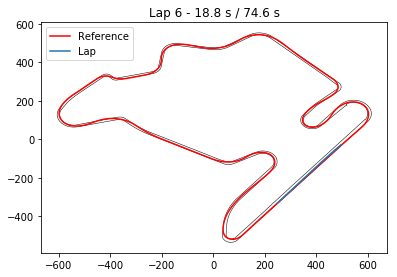

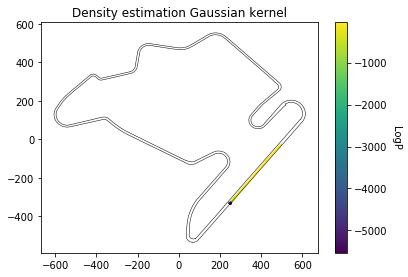

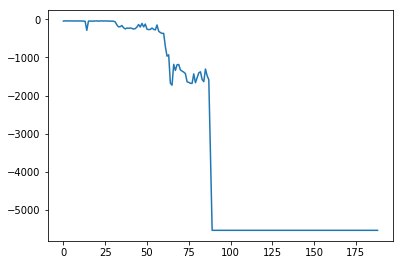

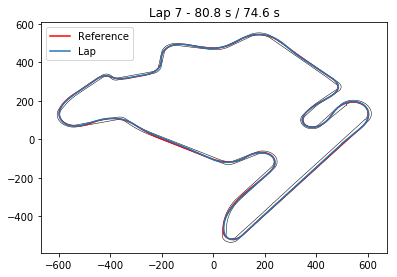

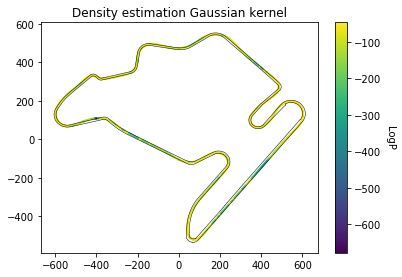

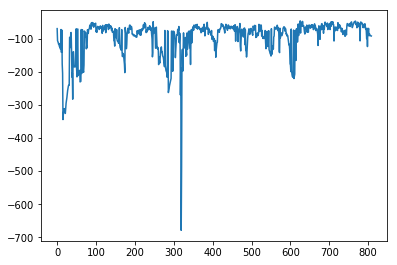

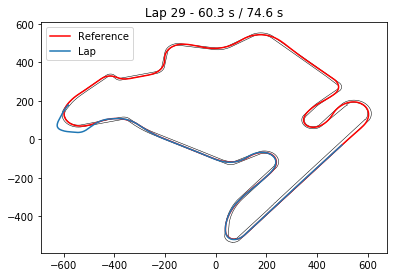

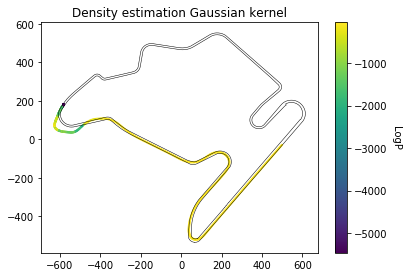

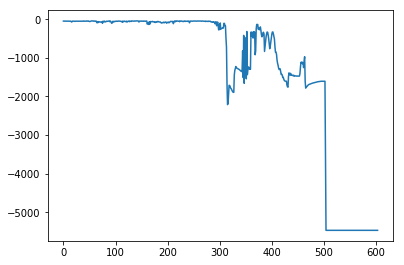

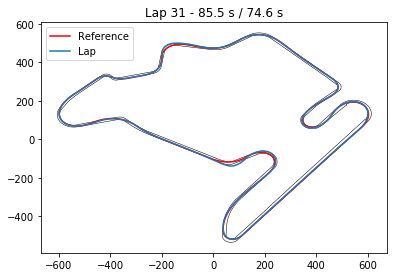

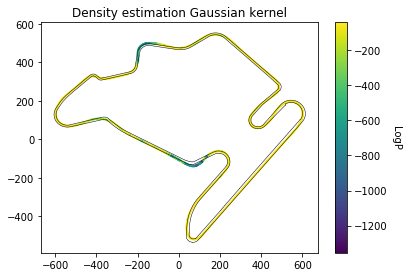

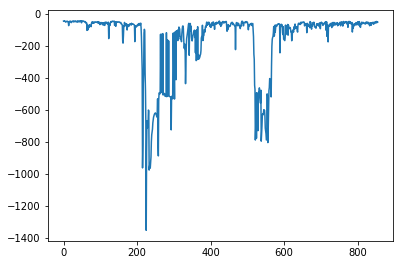

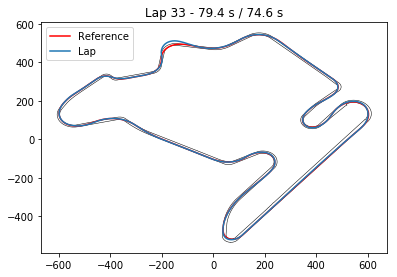

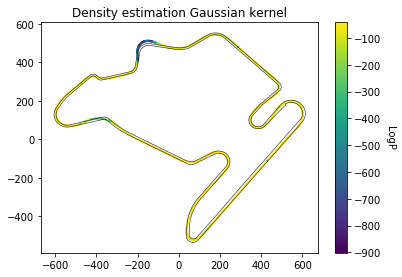

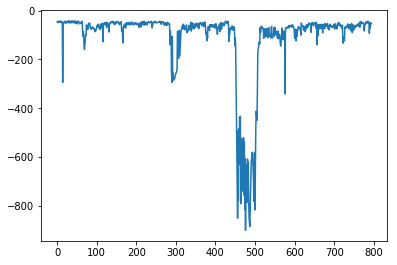

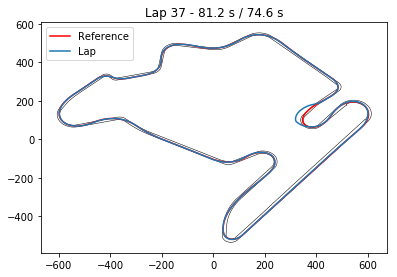

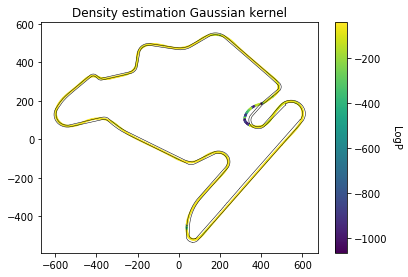

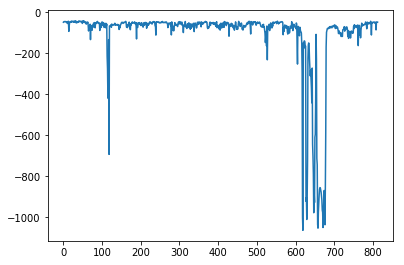

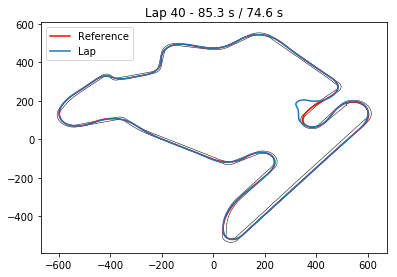

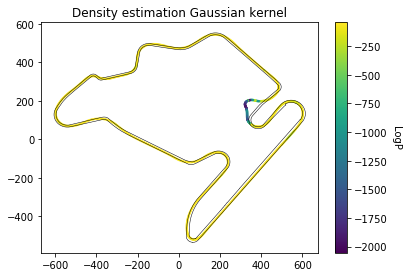

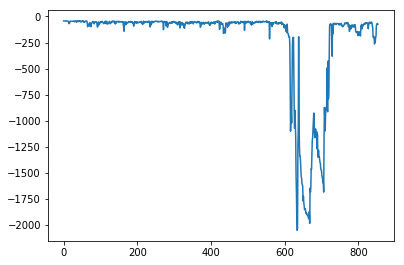

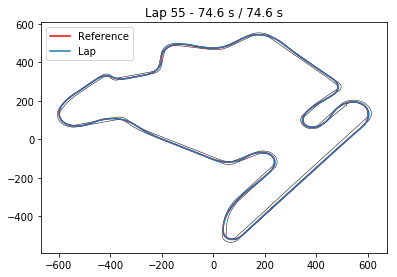

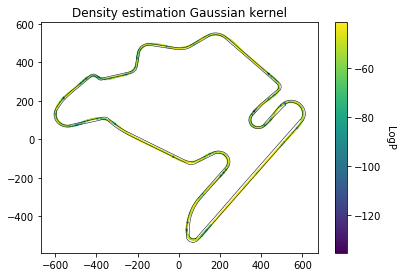

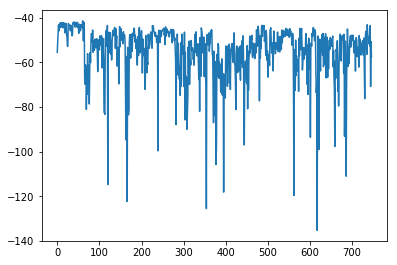

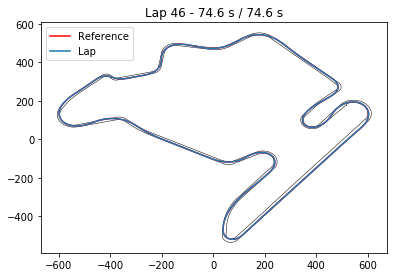

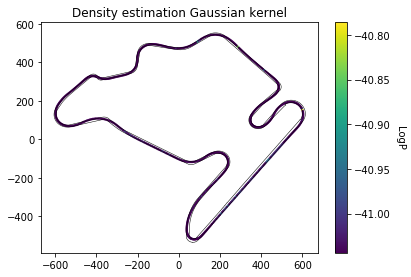

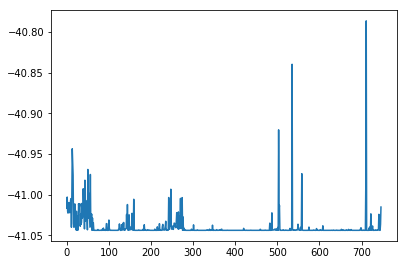

In [38]:
for lap in test_laps + [46]:
    f, ax = plot_track(track_in, track_out)
    plot_trajectories(simulation, lap, f, ax, simulation[simulation.NLap == 46])
    
    plot_proba(simulation[simulation.NLap == lap][['xCarWorld']].values,
               simulation[simulation.NLap == lap][['yCarWorld']].values,
               simulation[simulation.NLap == lap][state_cols].values,
               log=True, _3d=False)

# Hyperparameter tuning

In [40]:
%%latex
The new reward will be in the form $ r(s,a,s^{'}) = f(s,a) + \alpha \log p(s^{'}) $.
Since the high dimensionality of the state and few samples for each x,y pair the probability tends to be
low even for the reference trajectory. The value of $\alpha$ will be such that the second term of the equation will be
around 0 for states in the training set. Thus, we choose: \[ \alpha = \frac{1}{\frac{1}{N} \sum_{s \in T} \log p(s)} \]
where $ T $ is the set of states in the training set.

<IPython.core.display.Latex object>

In [26]:
train_log = kde.score_samples(simulation[simulation.NLap.isin(train_laps)][state_cols].values)
print('Max {}\nMean {}'.format(np.max(train_log), np.mean(train_log)))

Max -56.35231627521436
Mean -58.17490841704677


In [27]:
alpha = abs(1 / np.mean(train_log))
alpha

0.017189541457137452

Values of the second term for states in the training set

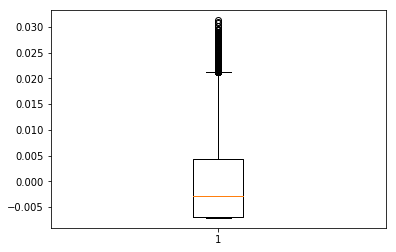

In [42]:
plt.boxplot(alpha * train_log + 1);

Values of the second term for *wrong* states

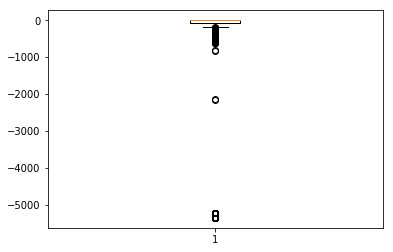

In [43]:
to_test = [6, 29, 33]
tmp = kde.score_samples(simulation[simulation.NLap.isin(to_test)][state_cols].values)
plt.boxplot(alpha * tmp + 1);

In [45]:
lg = kde.score_samples(simulation[simulation.NLap == 6][state_cols].values)

[ -59.16863107  -58.04763144  -58.11206998  -58.64123062  -58.45387082
  -58.34579965  -57.88923165  -58.33976027  -58.36870607  -58.6650176
  -58.25356237  -57.97078912  -58.90690424  -59.28129128  -90.09493515
  -58.65553101  -58.4298336   -58.60728621  -58.79343171  -57.98402976
  -57.80659187  -58.2426847   -57.81989517  -57.85054266  -57.99442506
  -57.79048335  -57.70124045  -58.08831212  -58.42190649  -58.49205658
  -58.95132657 -100.11869468 -182.9681139  -323.09414523 -305.25152947
 -356.11569573 -402.40849095 -528.70884084 -435.35939643 -465.65547142
 -148.31909833 -473.7027798   -96.95904778 -498.34121696 -336.50888632
 -137.73071554 -341.89503073 -106.72333392 -115.1419508  -122.01932781]


Text(0.5,1,'Density estimation')

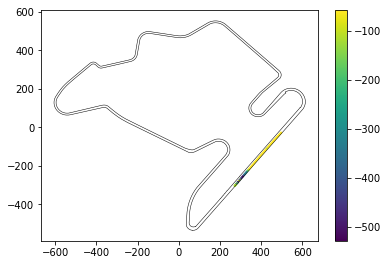

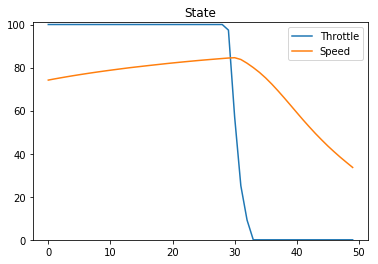

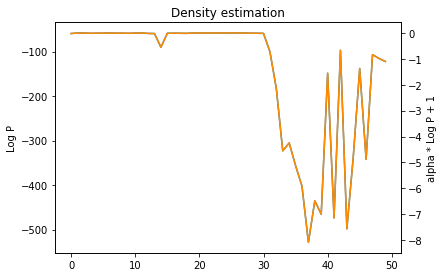

In [52]:
_int = range(50)
print(lg[_int])
f,ax = plot_track(track_in, track_out)
s=plt.scatter(simulation[simulation.NLap == 6]['xCarWorld'].values[_int],
            simulation[simulation.NLap == 6]['yCarWorld'].values[_int],
           c=lg[_int], s=2)
f.colorbar(s)

f = plt.figure()
plt.plot(simulation[simulation.NLap == 6]['rThrottlePedal'].values[_int])
plt.plot(simulation[simulation.NLap == 6]['actualSpeedModule'].values[_int])
plt.legend(['Throttle', 'Speed'])
plt.title('State')
plt.ylim([0, 101])

f = plt.figure()
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(lg[_int])
ax.set_ylabel('Log P')
axr = ax.twinx()
axr.plot(alpha * lg[_int] + 1, 'darkorange')
axr.set_ylabel('alpha * Log P + 1')
plt.title('Density estimation')

In [54]:
lg = kde.score_samples(simulation[simulation.NLap == 37][state_cols].values)

[   -90.88004983    -67.21732054    -93.49457824    -73.44934739
    -92.1683253     -86.82612834    -66.17421888    -66.31244008
    -71.33065047    -72.14872937    -58.86362147    -64.04052689
    -70.29505549    -82.78441562    -72.05133892    -61.8097648
    -61.78373554    -64.44743907    -67.10636134    -69.37761769
    -68.78133743    -74.61339875    -59.90017316    -61.43888078
   -213.19232645   -521.85660786    -67.7401419     -66.73344329
    -86.80743038    -90.84519029   -114.81164297    -68.98936256
    -74.90003253    -86.99324579    -91.90469243   -102.47612864
   -185.76929154   -732.4913364   -9582.08022911 -10879.65245515
   -239.09788178   -248.54477459   -161.34250251   -159.35155343
   -168.17757091   -222.41175431   -217.43779453  -8084.29320625
  -7757.64439106  -9789.38618645  -7834.05542058  -4857.96062748
   -405.9352148    -203.65705431   -180.48488505   -212.24238172
   -419.35998851   -590.01191766   -809.33790973   -662.35422215
   -899.06218894  -1182.47

Text(0.5,1,'Density estimation')

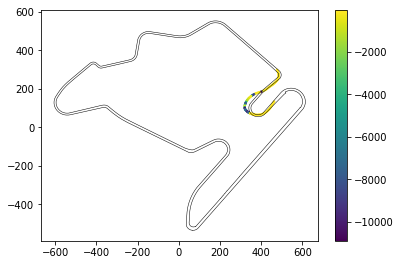

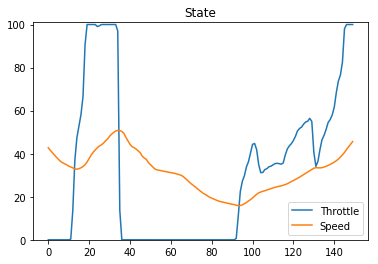

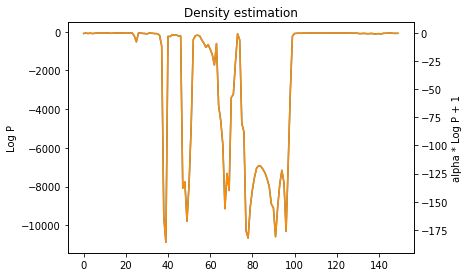

In [58]:
_int = range(580, 730)
print(lg[_int])
f,ax = plot_track(track_in, track_out)
s=plt.scatter(simulation[simulation.NLap == 37]['xCarWorld'].values[_int],
            simulation[simulation.NLap == 37]['yCarWorld'].values[_int],
           c=lg[_int], s=2)
f.colorbar(s)

f = plt.figure()
plt.plot(simulation[simulation.NLap == 37]['rThrottlePedal'].values[_int])
plt.plot(simulation[simulation.NLap == 37]['actualSpeedModule'].values[_int])
plt.legend(['Throttle', 'Speed'])
plt.title('State')
plt.ylim([0, 101])

f = plt.figure()
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(lg[_int])
ax.set_ylabel('Log P')
axr = ax.twinx()
axr.plot(alpha * lg[_int] + 1, 'darkorange')
axr.set_ylabel('alpha * Log P + 1')
plt.title('Density estimation')

# Reward comparison

In [7]:
from data_processing.sars.reward_function import *
from data_processing.sars.sars_creator import to_SARS

In [8]:
#{'bandwidth': 0.8858667904100825, 'kernel': 'exponential'}
penalty = LikelihoodPenalty(bandwidth=0.8858, kernel='exponential')
penalty.fit(simulation[simulation.NLap.isin(right_laps)][state_cols].values)

In [9]:
drf_wp = Discrete_temporal_reward(ref_tr, penalty=penalty, clip_range=(-np.inf, np.inf))
drf = Discrete_temporal_reward(ref_tr)

trf_wp = Temporal_projection(ref_tr, penalty=penalty, clip_range=(-np.inf, np.inf))
trf = Temporal_projection(ref_tr)

srf_wp = Speed_projection(ref_tr, penalty=penalty, clip_range=(-np.inf, np.inf))
srf = Speed_projection(ref_tr)

## Lap 5

In [10]:
lap = 5
dataset_with_p = to_SARS(simulation[simulation.NLap == lap], trf_wp)
dataset = to_SARS(simulation[simulation.NLap == lap], trf)

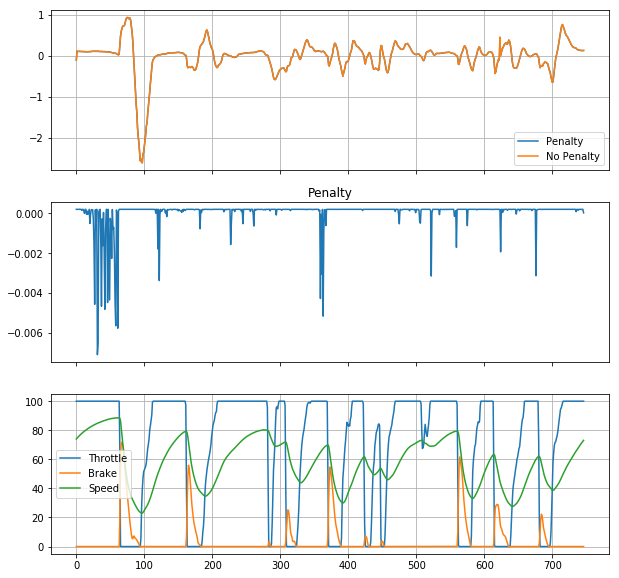

In [12]:
f, axs = plt.subplots(3, 1, sharex=True, figsize=[10,10])
axs[0].plot(dataset_with_p.r.values)
axs[0].plot(dataset.r.values)
axs[0].legend(['Penalty', 'No Penalty'])
axs[0].grid()

axs[1].plot(dataset.r.values - dataset_with_p.r.values)
axs[1].set_title('Penalty')

axs[2].plot(dataset.rThrottlePedal.values)
axs[2].plot(dataset.pBrakeF.values)
axs[2].plot(dataset.actualSpeedModule.values)
axs[2].legend(['Throttle', 'Brake', 'Speed'])
axs[2].grid()

## Lap 6

In [12]:
lap = 6
dataset_with_p = to_SARS(simulation[simulation.NLap == lap], trf_wp)
dataset = to_SARS(simulation[simulation.NLap == lap], trf)

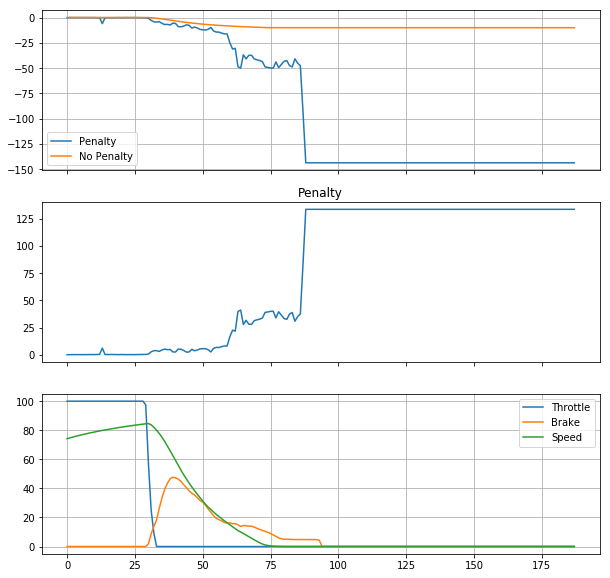

In [13]:
f, axs = plt.subplots(3, 1, sharex=True, figsize=[10,10])
axs[0].plot(dataset_with_p.r.values)
axs[0].plot(dataset.r.values)
axs[0].legend(['Penalty', 'No Penalty'])
axs[0].grid()

axs[1].plot(dataset.r.values - dataset_with_p.r.values)
axs[1].set_title('Penalty')

axs[2].plot(dataset.rThrottlePedal.values)
axs[2].plot(dataset.pBrakeF.values)
axs[2].plot(dataset.actualSpeedModule.values)
axs[2].legend(['Throttle', 'Brake', 'Speed'])
axs[2].grid()

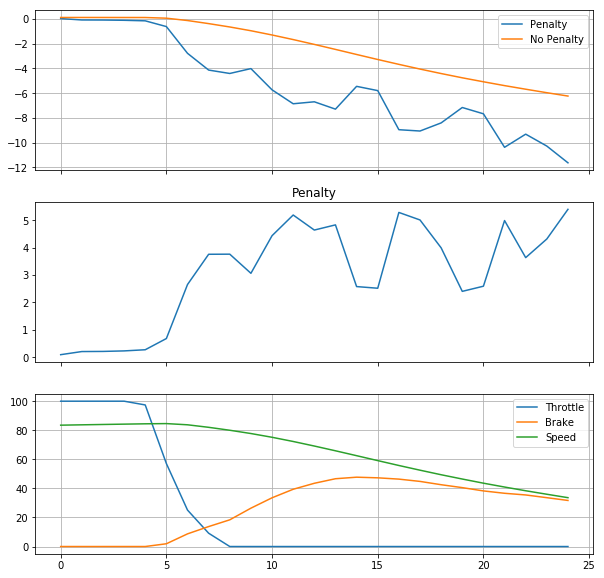

In [14]:
f, axs = plt.subplots(3, 1, sharex=True, figsize=[10,10])
_int = range(25, 50)

axs[0].plot(dataset_with_p.r.values[_int])
axs[0].plot(dataset.r.values[_int])
axs[0].legend(['Penalty', 'No Penalty'])
axs[0].grid()

axs[1].plot(dataset.r.values[_int] - dataset_with_p.r.values[_int])
axs[1].set_title('Penalty')

axs[2].plot(dataset.rThrottlePedal.values[_int])
axs[2].plot(dataset.pBrakeF.values[_int])
axs[2].plot(dataset.actualSpeedModule.values[_int])
axs[2].legend(['Throttle', 'Brake', 'Speed'])
axs[2].grid()

## Lap 7

In [15]:
lap = 7
dataset_with_p = to_SARS(simulation[simulation.NLap == lap], trf_wp)
dataset = to_SARS(simulation[simulation.NLap == lap], trf)

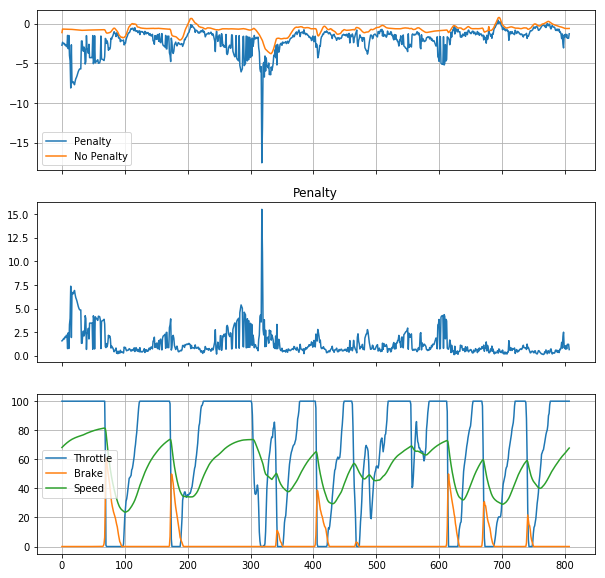

In [16]:
f, axs = plt.subplots(3, 1, sharex=True, figsize=[10,10])
axs[0].plot(dataset_with_p.r.values)
axs[0].plot(dataset.r.values)
axs[0].legend(['Penalty', 'No Penalty'])
axs[0].grid()

axs[1].plot(dataset.r.values - dataset_with_p.r.values)
axs[1].set_title('Penalty')

axs[2].plot(dataset.rThrottlePedal.values)
axs[2].plot(dataset.pBrakeF.values)
axs[2].plot(dataset.actualSpeedModule.values)
axs[2].legend(['Throttle', 'Brake', 'Speed'])
axs[2].grid()